# Sampling Algorithms

采样或者抽样，其实是指从一个概率分布中生成观察值（observations）的方法，而这个分布通常是由其概率密度函数（PDF）来表示的。而且，即使在已知PDF的情况下，让计算机自动生成观测值也不是一件容易的事情。从本质上来说，计算机只能实现对均匀分布（Uniform distribution）的采样。 那如何实现计算机很好的采样数据样本呢？今天我们一起来看看实现方法。

主要**参考资料**：

- [An Introduction to Statistical Computing: A Simulation-based Approach, Jochen Voss](https://www.wiley.com/en-us/An+Introduction+to+Statistical+Computing%3A+A+Simulation+based+Approach-p-9781118357729)
- [接受拒绝采样（Acceptance-Rejection Sampling）](https://blog.csdn.net/Anne033/article/details/109841951)

在大多数实际场景中，分布很复杂，以至于很难从适当的地方采样，不过通常可以在某点进行评估，所以有办法帮助采样。由于几个原因，没有那种统一一种的采样策略：

1. 随着维度数量的增加，这很快就会变得低效。

2. 在高维空间中，存在着广阔的虚无区域，大部分概率密度集中在一个小区域内。理想情况下，我们希望从空间中函数 f(x) 和 p(x) 给出的 f(x) 的概率 很高的区域进行采样，即 \\(f(x) p (x)\\) 贡献高的地方采样。

下面看看执行有效采样的方法。这不仅有助于了解如何在 SciPy 之类的包中实践中对分布进行采样，而且还可以帮助在需要时编写自己的自定义分布。

列出的技术大多适用于单变量分布，但它们有助于理解，因为它们是基础。

## Sampling from Discrete Distributions

### Uniform Continuous to Uniform Discrete

* 为了从特定分布中采样数据，我们可以从 0 到 1 之间的均匀连续分布开始，U[0,1]。选择小于 'a' 且介于 0 和 1 之间的值的概率由下式给出

$$P(x < a) = a$$

但是因为 0 和 1 之间有无限的可能性，所以选择任何特定值 'a' 的概率接近于 0。

* 如果我们想要一个任意连续分布 U[0,k]，将 U[0,1] 乘以 k 得到缩放分布

* 如果我们有一个从 0 到 'n' 的离散均匀分布，表示为 U{0,1,...n-1}，这个集合有 'n' 个样本，并且选择任何离散值 'a' 的概率是

$$P(x = a) = \dfrac{1}{n}$$

因为这是一个离散值，并且该集合中的元素数量有限。将这种连续均匀分布 U[0,1] 转换为 离散分布 U{0,1,...n-1} 的方法是通过 X = [[n U]]转换。这里使用符号 [[ ]] 表示将值四舍五入到最接近的 整数。只要做了这个转换，就有了离散均匀发布

$$X \sim U \{0,1,...n-1\}$$

也就是说，直接连续区间上随机采样就行，然后将值四舍五入，就得到了离散均匀分布的采样值了。

### Arbitrary (Non-uniform) Discrete Distributions

要生成任意分布，我们可以使用连续均匀分布并从中采样，然后进行变换，以便获得所需的分布。在下图中，我们将均匀连续分布 U[0,1] 的区间划分为长度不均匀的 'n' 个部分，由 \\(p_1, p_2, p_3...p_n\\) 给出（这里 n = 5）这样 \\(\sum p_i = 1\\)

![Interval Transformation](pictures/transformation.png)

如果我们想从任意离散集合 \\(A = \{a_1, a_2...a_n\}\\) 中采样，概率为 \\(p_1, p_2, p_3...p_n\\) 我们要做的是从均匀连续分布 U[0,1] 中采样，**因为区间 \\(i\\) 将以概率 \\(p_i\\) 与集合元素 \\(a_i\\) 对应**。

也就是说，在0到1上均匀分布抽，抽完之后，抽出来的值在划分的哪个p表示的区间就归属到对应的哪个a值，这最后抽样的结果就是符合这个A的分布的。比如上面5个离散值，我均匀分布抽100次，肯定比较多的会抽到P2上，那么最后出来画个histogram，肯定是P2那块出现的次数多的，这样分布就对上了。这个思路后面还会用到。

## The Inverse Transform Method

此方法使用累积分布函数 (CDF) 和 CDF 的逆来生成我们想要的分布。

如果通过将函数“F”应用于“X”生成变量“Y”，我们得到

$$Y = F(X)$$

这意味着我们可以对“Y”（如果存在）应用逆变换以获得“X”。这里函数'F'必须是可逆的。函数“F”被称为是双射的，其行为没有跳跃。

$$F^{-1} (Y) = X$$

从现有分布生成新分布所需的步骤如下所示。

### Derivation

如果 'y' 是 'z' 的函数，其中

* y 的 PDF 由 p(y) 和

* z 的 PDF 由 p(z) 给出

$$y = f(z)$$

***我们想要确定函数 f(z) 使得由变换 \\( y = f(z)\\) 形成的值 'y' 的分布是我们想要的分布。***

'y' 的分布将遵循以下规则

$$ p(y) = p(z) \lvert \dfrac{dz}{dy} \rvert$$

如果“z”具有均匀分布，则变为

$$p(y) = \lvert \dfrac{dz}{dy} \rvert$$

两边积分，我们得到

$$z = \int^y_{-\infty} p(y) dy = h(y)$$ 

查看此积分，可以发现z是“y”的 CDF（h(y) 是“y”的 CDF）。如果我们应用 CDF 函数的逆函数，即 \\(h^{-1}\\)，在两边我们得到

$y = h^{-1} (z)$

此转换的目的是将“y”表示为“z”的函数。如果我们从 'z' 分布中采样，用所需分布 (y) 的 CDF 的逆变换值，我们将得到具有所需分布的 'y' 值

### Algorithm

1. 计算所需分布的 CDF 的倒数，由 \\(F^{-1}\\) 给出

2. 从“z” U[0,1] 采样

3. 使用2中的采样值作为 CDF $F^{-1}$ 的逆的输入，使得

    $$Y \sim F^{-1} (U)$$
    
这种方法的局限性在于必须可以计算分布的 CDF 的倒数。

### Example

指数分布由 PDF 给出

$$p(y) = \lambda e^{-\lambda y}$$ 

如果 y >= 0

此分布的 CDF 由下式给出

$$F = 1 - e^{-\lambda y}$$

$$ F = h(y) = z \longrightarrow z = 1 - e^{-\lambda y} $$

等式两边取对数

$$ y = -log(1 - z) / \lambda $$

现在，如果您从 'z' 中采样并将这些值代入上面的等式中，您将得到具有所需分布的 'y' 值。

Text(0.5, 1.0, 'Analytical form of the desired Exponential distribution')

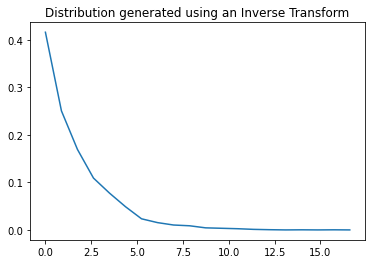

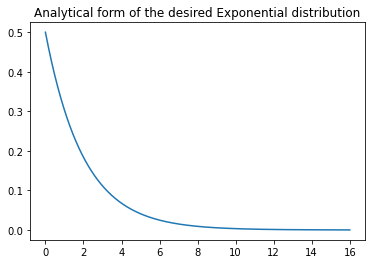

In [1]:
import numpy as np
from scipy.stats import expon
from matplotlib import pyplot as plt

# Generate random numbers
U = np.random.rand(5000)
lam = 0.5
X = -np.log(1 - U)/lam #transformations
hist, bin_edges = np.histogram(X, bins=20, density=True) #histogram of the transformed variables
plt.plot(bin_edges[0:-1], hist) #ideally should center the hist values to be the average of bin edges
plt.title("Distribution generated using an Inverse Transform")
# Get analytical PDF
plt.figure()
x = np.linspace(0, 16, 1000)
Y = expon.pdf(x,0,1/lam)
plt.plot(x, Y)
plt.title("Analytical form of the desired Exponential distribution")

## Rejection Sampling

拒绝抽样比上面列出的技术更复杂。它生成近似正确的分布，并使用拒绝抽样来纠正近似引入的错误，从而产生正确的分布。拒绝抽样基于以下原则。假设我们要从密度为 \\(p(z)\\) 的分布中进行采样。

1. 称为proposal提议密度\\(q(z)\\) 的概率密度。选择此密度以使其比原始分布密度 \\(p(z)\\) 更容易采样。

2. \\(p(z)\\) 很难采样，但我们可以评估它直到某个比例常数。

3. 一个常数 'k' 使得对于 'z' 的所有值 \\(k q(z) >= p(z)\\) 。这在 p(z) 周围形成了一个包络，用 \\(kq(z)\\) 表示

![Sampling](pictures/sampling_distribution.png)

给定上述密度，我们使用以下步骤

1. 从 \\(q(z)\\) 中取 \\(z_0\\) 并计算密度 \\(k q(z_0)\\)

2. 从密度的区间 \\([0, k q(z_0)]\\) 均匀分布地抽样一个数 \\(u_0\\)

3.如果\\(u_0 > p(z_0)\\)，则样本被拒绝，否则保存\\(u_0\\)。通过这样做，任何属于 \\(p(z)\\) 的东西都被保存并具有均匀分布，从而获得 \\(p(z)\\) 的分布
       
4. 继续（1）直到抽取足够的样本

也就是说，通过这种方式就得到了在密度曲线以下的这块区域（上图粉色）里的这些点。这些点满足什么分布？均匀分布！这是拒绝采样最关键的部分，搞个建议分布、向建议分布里投点等等，所做的一切都是为了获得一个密度曲线所围成区域的均匀分布。只要能获得这样一个在密度曲线下满足均匀分布的样本，我们就可以获得与该密度曲线相匹配的随机变量的采样样本。方法是，只需把粉色区域中每个点的横坐标提取出来，这些横坐标所构成的样本就是我们的目标样本。这时候把这些点的histogram画出来就会和我们想要的分布一致。这个逻辑和上面任意离散分布的抽样的逻辑是一样的。

样本被接受的概率为 \\(\dfrac{p(z)}{k q(z)}\\)。对于有效的拒绝采样，我们希望被拒绝的样本数量最少。这只有在包络分布接近所需分布时才有可能。由于以下原因，在高维空间中使用也是低效的

* 'D' 维空间中 k 的理想值由 \\( (\dfrac{\sigma_q}{\sigma_p})^D\\) 给出，其中 \\(\sigma\\) 是两者的分布的方差。

* 密度为 \\(p(x)\\) 和 \\(q(x)\\) 的两个均匀分布的接受率只是 \\(1/k\\)

* 该接受率现在按比例 \\( (\dfrac{\sigma_p}{\sigma_q})^D\\) 缩放。如果 \\( \sigma_q\\) 比 \\( \sigma_p\\) 大 1%，对于 D = 1000，接受率现在接近 1/20000。

* 在分布是多峰的实际场景中，这种影响会加剧。

## Importance Sampling

重要性采样可**用于计算诸如具有分布 \\(p(x)\\) 的函数 \\(f(x)\\) 的期望**等项。理想情况下，我们希望在乘积 \\(f(x) p(x)\\) 高的空间中进行采样，因为离散分布的期望值计算为

$$E[f] = \sum_i p(x_i) f(x_i)$$

或者，对于连续分布为

$$E[f] = \int p(x) f(x) dx $$

重要性抽样也是基于使用另一个比原始分布 \\(p(x)\\) 更容易抽样的提议分布的想法。

$$E[f] = \int p(x) f(x) dx = \int \dfrac{p(x)}{q(x)} q(x) f(x) dx \approx \dfrac{1 }{L} \sum_l^{drawn\;from\;Q(x)} \dfrac{p(x)}{q(x)} f(x) $$ 其中样本是从 q(x) 而不是难以抽样的分布 p(x)中抽的。

这里其实已经用到蒙特卡洛思想了，后面会进一步介绍。

术语 \\(\dfrac{p(x)}{q(x)}\\) 被称为“重要性权重”，并纠正从错误分布中抽样所导致的偏差。与拒绝抽样不同的是，保留所有样本。与拒绝采样类似的是，包络分布应接近有效采样所需的分布。